In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def create_comparation_table_clustering(pred, X, labels, dict_class_types, class_label):
    ''' Create a dataframe with the values of all the features (denoted by X) and the label results
    of the clustering algorithm, plus class names (table denoted by yhat). Also, returns a comparision table
    with the presence of each class type with each cluster type, if present.
    
    Args:
        - pred (pd.DataFrame): class prediction result
        - X (pd.DataFrame): features dataset, input for prediction
        - labels (pd.Series): true labels of the original dataset
        - dict_class_types (dict): dict with keys being the true class number and values with names.
        - class_label (pd.DataFrame): dataframe with information about data classes (number and name)
        
    Returns:
        - yhat (pd.DataFrame): dataframe with all the feature values plus the results of the model
        - comp_table (pd.DataFrame): dataframe with the results of the clustering model, plus calculations of the presence.
        
        
    '''    
    
    # Create dataframe with features plus prediction values
    yhat = X.copy()
    yhat['cluster_label'] = pred
    yhat['class_label'] = labels
    yhat['class_name'] = yhat['class_label'].replace(dict_class_types)
    
    # Create comparision table with results
    check_labels_w_names = yhat.groupby(['class_label','cluster_label']).size().reset_index()
    check_labels_w_names['class_name'] = check_labels_w_names['class_label'].replace(dict_class_types)
    check_labels_w_names = check_labels_w_names.set_index(['class_name', 'class_label'])
    check_labels_w_names = pd.merge(check_labels_w_names.reset_index(), class_label[['Class_Number', 'Number_Of_Animal_Species_In_Class']], 
            'left', left_on = 'class_label', right_on = 'Class_Number')
    check_labels_w_names = check_labels_w_names.rename({'Number_Of_Animal_Species_In_Class': 'class_total_number',
                                                        0: 'cluster_total_number'}, axis = 1)
    check_labels_w_names['presence_relative_to_class'] = np.round(check_labels_w_names['cluster_total_number']/check_labels_w_names['class_total_number'],3)
    comp_table = check_labels_w_names.set_index(['class_name', 'class_label'])

    return yhat, comp_table

# Data

In [3]:
zoo = pd.read_csv('../data/zoo.csv')
class_label = pd.read_csv('../data/class.csv')

- First, we see that fot not every animal class we have the same number of rows. In this dataset, the less frequent type of animal are the amphibians, and the most common the mammals. This makes sense for a zoo, which contains a variety of different animals.

In [4]:
class_label

,Class_Number,Number_Of_Animal_Species_In_Class,Class_Type,Animal_Names
0,1,41,Mammal,"aardvark, antelope, bear, boar, buffalo, calf,..."
1,2,20,Bird,"chicken, crow, dove, duck, flamingo, gull, haw..."
2,3,5,Reptile,"pitviper, seasnake, slowworm, tortoise, tuatara"
3,4,13,Fish,"bass, carp, catfish, chub, dogfish, haddock, h..."
4,5,4,Amphibian,"frog, frog, newt, toad"
5,6,8,Bug,"flea, gnat, honeybee, housefly, ladybird, moth..."
6,7,10,Invertebrate,"clam, crab, crayfish, lobster, octopus, scorpi..."


- As it is stated on the source page of the dataset, the zoo dataframe contains information about characteristics of each animal. Mostly of the features are of boolean type, except for _legs_ which is a numerical column. This is the dataset we will use to analyze information and to develop our model.

In [6]:
zoo

,animal_name,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize,class_type
0,aardvark,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,1
1,antelope,1,0,0,1,0,0,0,1,1,1,0,0,4,1,0,1,1
2,bass,0,0,1,0,0,1,1,1,1,0,0,1,0,1,0,0,4
3,bear,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,1
4,boar,1,0,0,1,0,0,1,1,1,1,0,0,4,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,wallaby,1,0,0,1,0,0,0,1,1,1,0,0,2,1,0,1,1
97,wasp,1,0,1,0,1,0,0,0,0,1,1,0,6,0,0,0,6
98,wolf,1,0,0,1,0,0,1,1,1,1,0,0,4,1,0,1,1
99,worm,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,7


# Analysis

## EDA

- First, let's see the presence of each of the variables in the dataset.
- Since the majority of these features are boolean (legs is numerical, and class_type is the label to verify our results), computing the mean is equivalent to the percentage of rows that are true for that feature.

In [7]:
zoo.describe().loc['mean']

hair          0.425743
feathers      0.198020
eggs          0.584158
milk          0.405941
airborne      0.237624
aquatic       0.356436
predator      0.554455
toothed       0.603960
backbone      0.821782
breathes      0.792079
venomous      0.079208
fins          0.168317
legs          2.841584
tail          0.742574
domestic      0.128713
catsize       0.435644
class_type    2.831683
Name: mean, dtype: float64

- For future data wrangling, we divide some of the features into defined lists

In [8]:
non_boolean_features = ['legs', 'class_type']
numerical_features = ['legs']
animal_names_column = ['animal_name']


col_set = set(list(zoo.columns))
boolean_features = col_set-set(non_boolean_features+animal_names_column)
boolean_features_w_class = col_set - set(numerical_features+animal_names_column)

- The majority of animals of our dataset possess a backbone, breathes and have tail. Since a large part of the dataset consists of mammals, the presence of these features make sense.
- If we want to make clusters, we should note that it is important to distinguish as much as possible each type of animal.

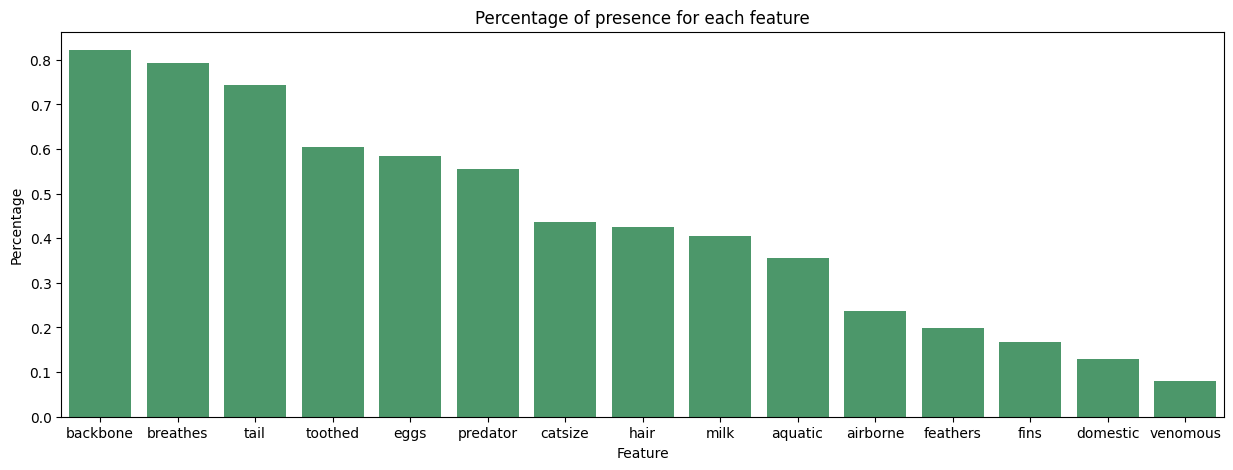

In [9]:
plt.figure( figsize = (15,5))

ax = sns.barplot(data = zoo.describe().loc['mean'].drop(non_boolean_features).sort_values(ascending = False),
                 color = sns.xkcd_rgb['greenish'])

ax.set_title('Percentage of presence for each feature')
ax.set_xlabel('Feature')
ax.set_ylabel('Percentage')

plt.show()

- If we take a look into the animals that don't possess a backbone, we can see that is mainly shellfishes and insects.

In [10]:
zoo[zoo['backbone'] != 1]

,animal_name,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize,class_type
13,clam,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,7
14,crab,0,0,1,0,0,1,1,0,0,0,0,0,4,0,0,0,7
15,crayfish,0,0,1,0,0,1,1,0,0,0,0,0,6,0,0,0,7
24,flea,0,0,1,0,0,0,0,0,0,1,0,0,6,0,0,0,6
30,gnat,0,0,1,0,1,0,0,0,0,1,0,0,6,0,0,0,6
39,honeybee,1,0,1,0,1,0,0,0,0,1,1,0,6,0,1,0,6
40,housefly,1,0,1,0,1,0,0,0,0,1,0,0,6,0,0,0,6
42,ladybird,0,0,1,0,1,0,1,0,0,1,0,0,6,0,0,0,6
46,lobster,0,0,1,0,0,1,1,0,0,0,0,0,6,0,0,0,7
51,moth,1,0,1,0,1,0,0,0,0,1,0,0,6,0,0,0,6


In [11]:
zoo[zoo['backbone'] != 1].groupby('class_type').size()

class_type
6     8
7    10
dtype: int64

- Also, the animals that don't breathe are mostly fish.

In [12]:
zoo[zoo['breathes'] != 1]

,animal_name,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize,class_type
2,bass,0,0,1,0,0,1,1,1,1,0,0,1,0,1,0,0,4
7,carp,0,0,1,0,0,1,0,1,1,0,0,1,0,1,1,0,4
8,catfish,0,0,1,0,0,1,1,1,1,0,0,1,0,1,0,0,4
12,chub,0,0,1,0,0,1,1,1,1,0,0,1,0,1,0,0,4
13,clam,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,7
14,crab,0,0,1,0,0,1,1,0,0,0,0,0,4,0,0,0,7
15,crayfish,0,0,1,0,0,1,1,0,0,0,0,0,6,0,0,0,7
18,dogfish,0,0,1,0,0,1,1,1,1,0,0,1,0,1,0,1,4
34,haddock,0,0,1,0,0,1,0,1,1,0,0,1,0,1,0,0,4
38,herring,0,0,1,0,0,1,1,1,1,0,0,1,0,1,0,0,4


In [13]:
zoo[zoo['breathes'] != 1].groupby('class_type').size()

class_type
3     1
4    13
7     7
dtype: int64

- As we can see, most of the animals are mammals, birds and fishes.

In [14]:
class_label.rename({'Class_Type': 'class_type'}, axis = 1).set_index('class_type')['Number_Of_Animal_Species_In_Class']

class_type
Mammal          41
Bird            20
Reptile          5
Fish            13
Amphibian        4
Bug              8
Invertebrate    10
Name: Number_Of_Animal_Species_In_Class, dtype: int64

- Refering to the last behaviour we noticed, there seems to be "unique" features for certain types of classes. For example, mammals (class 1) are the ones that only drink milk. Another example could be the presence of fins, which are mostly present in the fish class (number 4). The same thing with feathers and the bird class.  

- In general we see that many features have explainibility on the majority of classes.

In [15]:
pd.concat([zoo[list(boolean_features_w_class)].groupby('class_type').mean(),
           class_label.rename({'Class_Number': 'class_type'}, axis = 1).set_index('class_type')['Number_Of_Animal_Species_In_Class'].rename('size')], 
          axis = 1)

,aquatic,toothed,backbone,domestic,milk,airborne,catsize,fins,tail,eggs,predator,breathes,feathers,venomous,hair,size
class_type,,,,,,,,,,,,,,,,
1,0.146341,0.97561,1.0,0.195122,1.0,0.04878,0.780488,0.097561,0.853659,0.02439,0.536585,1.0,0.0,0.000000,0.95122,41
2,0.300000,0.00000,1.0,0.150000,0.0,0.80000,0.300000,0.000000,1.000000,1.00000,0.450000,1.0,1.0,0.000000,0.00000,20
3,0.200000,0.80000,1.0,0.000000,0.0,0.00000,0.200000,0.000000,1.000000,0.80000,0.800000,0.8,0.0,0.400000,0.00000,5
4,1.000000,1.00000,1.0,0.076923,0.0,0.00000,0.307692,1.000000,1.000000,1.00000,0.692308,0.0,0.0,0.076923,0.00000,13
5,1.000000,1.00000,1.0,0.000000,0.0,0.00000,0.000000,0.000000,0.250000,1.00000,0.750000,1.0,0.0,0.250000,0.00000,4
6,0.000000,0.00000,0.0,0.125000,0.0,0.75000,0.000000,0.000000,0.000000,1.00000,0.125000,1.0,0.0,0.250000,0.50000,8
7,0.600000,0.00000,0.0,0.000000,0.0,0.00000,0.100000,0.000000,0.100000,0.90000,0.800000,0.3,0.0,0.200000,0.00000,10


- The next heatmap could visualize better this situation.
- This will be the main way that we can visualize the characterization of each class, because it's easier to see the impact of each feature for each class.

In [23]:
gb = pd.concat([zoo[list(boolean_features_w_class)].groupby('class_type').mean(),
           class_label.rename({'Class_Number': 'class_type'}, axis = 1).set_index('class_type')['Number_Of_Animal_Species_In_Class'].rename('size')], 
          axis = 1)

dict_class_types = dict(zip(class_label['Class_Number'], class_label['Class_Type']))
gb.index = [dict_class_types[x] for x in gb.index]

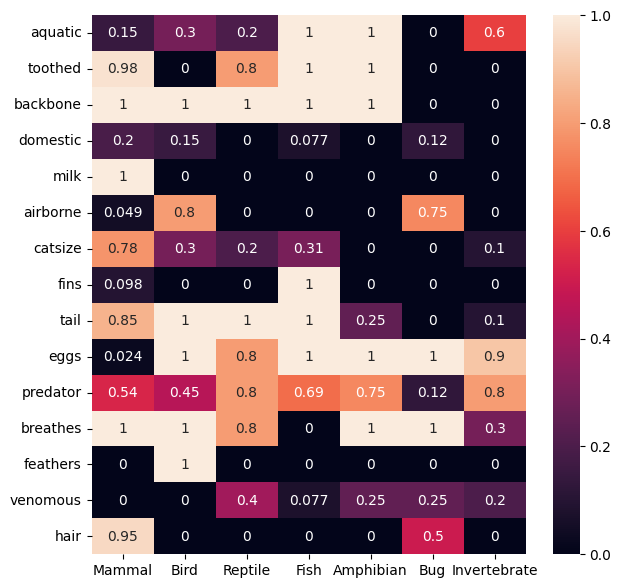

In [24]:
plt.figure(figsize = (7,7))

sns.heatmap(gb.drop('size', axis = 1).T, annot = True)

plt.show()

- The platypus, a special type of mammal that lays eggs.

In [20]:
zoo[(zoo['eggs'] == 1) & (zoo['class_type'] == 1)]

,animal_name,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize,class_type
63,platypus,1,0,1,1,0,1,1,0,1,1,0,0,4,1,0,1,1


In [21]:
zoo['class_names'] = zoo['class_type'].replace(dict_class_types)

- We can say that mainly there's more animals between 0 and 4 legs, with some classes being more frequent in certain n° of legs.
- For example mammals (in this zoo), often have 4 legs, although is possible too to find them with 2 or even zero (less probable).
- All bugs have 6 legs, birds have 2 legs, and fishes have 0 legs. Also, reptiles are common with 0 and 4 legs. 
- Invertebrate animals are distributed between all number of legs.

- This, in combination with the other features, is very significant to identify the type of animal is present. Although, could our algorithm discover it by itself?

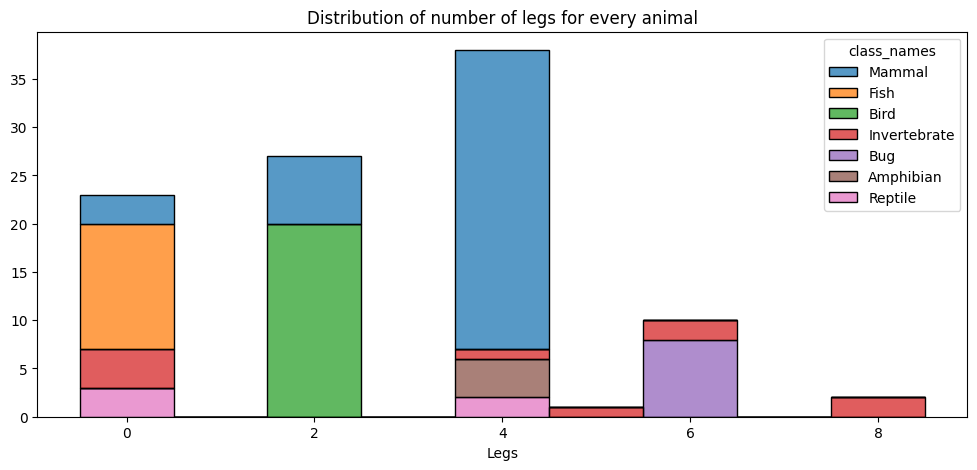

In [25]:
plt.figure(figsize = (12,5))

ax = sns.histplot(data = zoo, x ='legs' , 
                  hue ='class_names',
                  multiple = 'stack',
                  discrete = True)
ax.set_title('Distribution of number of legs for every animal')
ax.set_xlabel('Legs')
ax.set_ylabel('')

plt.show()

- We can see that airborne and aquatic are features present in the dataset, but what about the land animals?
- Creating a new variable could serve the algorithm, plus give us further insight
- If an animal doesn't have airborne nor aquatic qualities, we could classify it as a **land** animal

In [26]:
zoo.loc[(zoo['airborne'] != 1) & (zoo['aquatic'] != 1), 'land'] = 1
zoo['land'] = zoo['land'].fillna(0)
zoo['land'] = zoo['land'].astype(int)

- We have a particular situation. There are animals that are aquatic and also airborne.
- If we take a closer look (and without seeing the actual animal name), we can see that all of them possess feathers, which we can assume are from a particular class probably, "birds". Remember, our job is to classify only working with the features we have, *we dont know the classes yet*.

In [27]:
zoo[['land', 'aquatic', 'airborne']].sum(axis = 1).value_counts()

1    96
2     5
Name: count, dtype: int64

In [28]:
zoo[(zoo['aquatic'] == 1) & (zoo['airborne'] == 1)]

,animal_name,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize,class_type,class_names,land
21,duck,0,1,1,0,1,1,0,0,1,1,0,0,2,1,0,0,2,Bird,0
33,gull,0,1,1,0,1,1,1,0,1,1,0,0,2,1,0,0,2,Bird,0
78,skimmer,0,1,1,0,1,1,1,0,1,1,0,0,2,1,0,0,2,Bird,0
79,skua,0,1,1,0,1,1,1,0,1,1,0,0,2,1,0,0,2,Bird,0
87,swan,0,1,1,0,1,1,0,0,1,1,0,0,2,1,0,1,2,Bird,0


In [29]:
zoo.loc[(zoo['aquatic'] == 1) & (zoo['airborne'] == 1), ['aquatic', 'airborne']] = [0,1]

- Based on our criteria, land animals are the most present in the dataset.

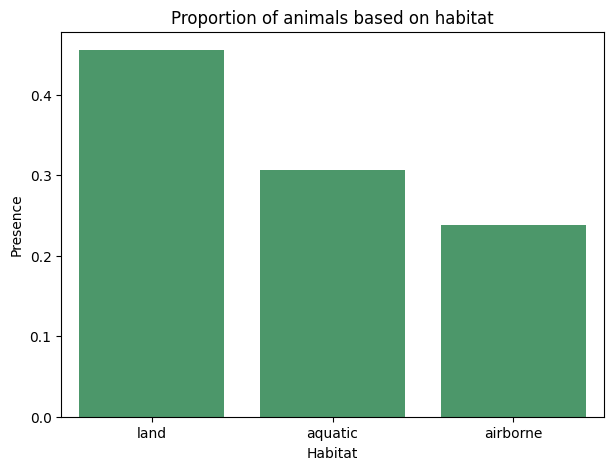

In [30]:
plt.figure(figsize = (7,5))

ax = sns.barplot(data = zoo[['land', 'aquatic', 'airborne']].mean(),
                 color = sns.xkcd_rgb['greenish'])

ax.set_title('Proportion of animals based on habitat')
ax.set_xlabel('Habitat')
ax.set_ylabel('Presence')

plt.show()

- To see the overall features of each variable, we create a heatmap.

In [31]:
zm = zoo.drop(non_boolean_features+['animal_name', 'class_names'], axis = 1).copy()

habitats = ['land', 'airborne', 'aquatic']
zm.loc[zm['land'] == 1, 'habitat'] = 'land'
zm.loc[zm['airborne'] == 1, 'habitat'] = 'airborne'
zm.loc[zm['aquatic'] == 1, 'habitat'] = 'aquatic'

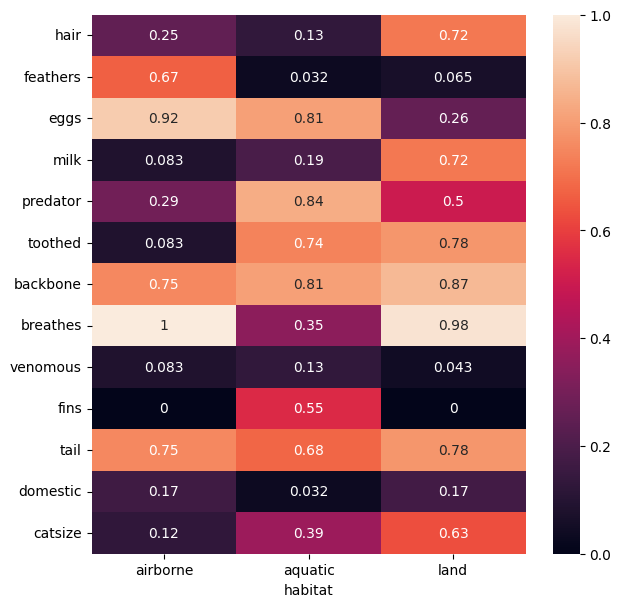

In [32]:
plt.figure(figsize = (7,7))

sns.heatmap(zm.drop(habitats, axis = 1).groupby(['habitat']).mean().T, annot = True)

plt.show()

- Since we made some modifications (added variables), we will export the new dataset for modeling.

In [41]:
#zoo.to_pickle('../data/zoo_mod.pkl')